### Importamos modulos

In [25]:
import numpy as np
from numpy import load
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop, SGD
import tensorflow as tf
from sklearn.metrics import confusion_matrix
%matplotlib inline
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
from src.comprobarImagen import comprobarImagen
from src.capturarImagen import capturarImagen
import seaborn as sns
from src.descargardataset import *
import cv2
import matplotlib.image as mpimg
import glob
import os



###  Cargamos Datasets

In [2]:
test_imagenes  = np.load('./Input/test_imagenes.npy')
test_etiqueta  = np.load('./Input/test_etiqueta.npy')
etiqueta_fruta = np.load('./Input/etiqueta_fruta.npy')
imagen_fruta   = np.load('./Input/imagen_fruta.npy')
nombre_frutas_corregido   = pd.read_csv("./Input/nombre_Frutas.csv")

### Organizamos los dataset en entrenamiento y pruebas

In [3]:
X_train, X_test = imagen_fruta, test_imagenes
y_train, y_test = etiqueta_fruta, test_etiqueta


#Hago una versión aplanada para algunos de nuestros modelos.
X_flat_train = X_train.reshape(X_train.shape[0], 35*35*3)
X_flat_test = X_test.reshape(X_test.shape[0], 35*35*3)

X_flat_train = X_flat_train/255
X_flat_test = X_flat_test/255 
#Categorizamos los valores de salida en un array de 50
y_train = keras.utils.to_categorical(y_train,num_classes =63)
y_test = keras.utils.to_categorical(y_test,num_classes =63)

#d2_train_dataset = train_dataset.reshape((nsamples,nx*ny))
print('Tamaños originales:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print('Tamaños cuando los modifiquemos:', X_flat_train.shape, X_flat_test.shape)

Tamaños originales: (70709, 35, 35, 3) (20624, 35, 35, 3) (70709, 63) (20624, 63)
Tamaños cuando los modifiquemos: (70709, 3675) (20624, 3675)


### Entrenamos el modelo

In [5]:
model = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model.add(Dense(128, activation='relu', input_shape=X_flat_train[1].shape))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.05))
model.add(Dense(28, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(35, activation='relu'))
model.add(Dropout(0.05))
# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(63, activation='softmax'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history_deep = model.fit(X_flat_train, y_train,
                          batch_size=300,
                          epochs=25,
                          verbose=1,
                          validation_data=(X_flat_test, y_test))
score = model.evaluate(X_flat_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               470528    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 28)                3612      
_________________________________________________________________
dropout_7 (Dropout)          (None, 28)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                1856      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

In [6]:
model.save('./Input/modelos/path_to_my_modelTesteado.h5')


### Para poder seguir enseñandolo si lo necesitara

In [9]:
new_model = load_model('./Input/modelos/path_to_my_modelTesteado.h5')
#assert_allclose(model.predict(x_train),new_model.predict(x_train),1e-5)

# fit the model
#checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
#callbacks_list = [checkpoint]
#new_model.fit(x_train, y_train, epochs=5, batch_size=50, callbacks=callbacks_list)

### Creamos matriz de confusión

In [10]:
y = model.predict(X_flat_test)
d = confusion_matrix(np.argmax(y, axis=1),np.argmax(y_test, axis=1))
display(d)

array([[2009,    0,    0, ...,    0,    0,    0],
       [   0,  155,    0, ...,    0,    0,    0],
       [   0,    0,  308, ...,    0,    0,    0],
       ...,
       [   7,    0,    0, ...,  166,    0,    0],
       [   0,    0,    0, ...,    0, 1317,    0],
       [   0,    0,    0, ...,    0,    0,  249]])

In [11]:
print(np.unique(test_etiqueta))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]


### Convertimosen un dataframe y lo preparamos para pintarlo

In [12]:
df_confusion = pd.DataFrame(d)

In [13]:
display(df_confusion)

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,2009,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,155,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,308,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,343,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,113,0,0,0,0,0,...,0,9,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,323,0,0,0,0
59,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,166,0,0,0
60,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,166,0,0
61,0,0,0,39,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,1317,0


In [14]:
corr_ma = df_confusion.corr()
corr_ma[corr_ma>0.8]


,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


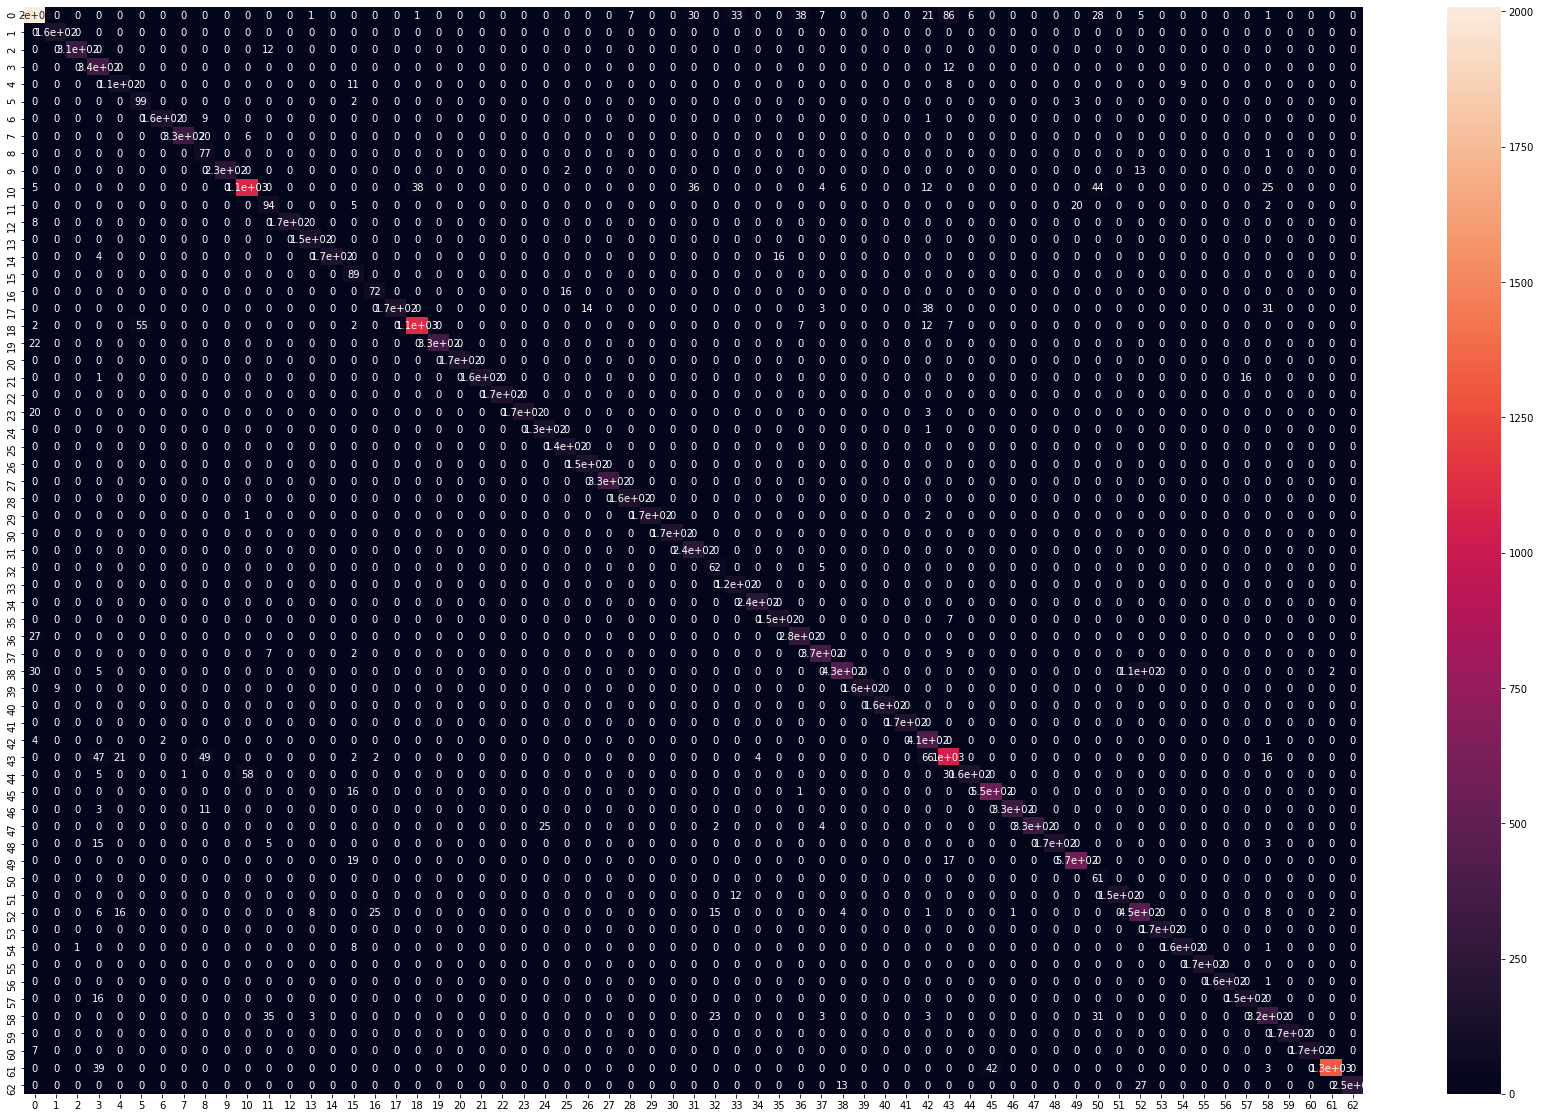

In [15]:
f, ax = plt.subplots(figsize=(30, 20))

sns.heatmap(df_confusion,annot=True)

In [20]:
capturarImagen()
comprobarImagen("./Output/imagenes/piña.jpg")

Fallo al  grabar imagen


NameError: name 'Error404' is not defined

# Vamos a intentar hacer distinción solo de 5 frutas, a ver si asi lo reconoze mejor en fotos externas al dataset


### Descargamos en nuevo dataset de solo 5 frutas para ello lo haremos con la transformada de Fourier

In [3]:
clase,imagenes_train = descargarDataset_FFT("./Output/Menos_Frutas/Training/*")

In [4]:
nombres_fruta ={elemento:indice for indice,elemento in enumerate(np.unique(clase))}
nombres_fruta

{'Apple Braeburn': 0, 'Banana': 1, 'Cocos': 2, 'Pineapple': 3, 'Strawberry': 4}

In [5]:
etiqueta_fruta = np.array([nombres_fruta[x] for x in clase])
etiqueta_fruta.shape,imagenes_train.shape

((2454,), (2454, 100, 100, 2))

In [6]:
df_etiquetas_train = pd.DataFrame(etiqueta_fruta)
print(df_etiquetas_train[0].value_counts())

4    492
0    492
3    490
1    490
2    490
Name: 0, dtype: int64


### Descargamos el dataset de test

In [7]:
clase_test,imagenes_test = descargarDataset_FFT("./Output/Menos_Frutas/Test/*")

In [8]:
nombres_fruta_test ={elemento:indice for indice,elemento in enumerate(np.unique(clase_test))}
nombres_fruta_test

{'Apple Braeburn': 0, 'Banana': 1, 'Cocos': 2, 'Pineapple': 3, 'Strawberry': 4}

In [9]:
etiqueta_fruta_test = np.array([nombres_fruta_test[x] for x in clase_test])
etiqueta_fruta_test.shape,imagenes_test.shape

((826,), (826, 100, 100, 2))

In [10]:
df_etiquetas = pd.DataFrame(etiqueta_fruta_test)
print(df_etiquetas[0].value_counts())


3    166
2    166
1    166
4    164
0    164
Name: 0, dtype: int64


### Vamos a iniciar el modelo de red neuronal

### Sacamos el X y el y para entrenar

In [11]:
X_train, X_test = imagenes_train, imagenes_test
y_train, y_test = etiqueta_fruta, etiqueta_fruta_test


#Hago una versión aplanada para algunos de nuestros modelos.
X_flat_train = X_train.reshape(X_train.shape[0], 100*100*2)
X_flat_test = X_test.reshape(X_test.shape[0], 100*100*2)

#X_flat_train = X_flat_train/255
#X_flat_test = X_flat_test/255 
#Categorizamos los valores de salida en un array de 5
y_train = keras.utils.to_categorical(y_train,num_classes =5)
y_test = keras.utils.to_categorical(y_test,num_classes =5)

#d2_train_dataset = train_dataset.reshape((nsamples,nx*ny))
print('Tamaños originales:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print('Tamaños cuando los modifiquemos:', X_flat_train.shape, X_flat_test.shape)

Tamaños originales: (2454, 100, 100, 2) (826, 100, 100, 2) (2454, 5) (826, 5)
Tamaños cuando los modifiquemos: (2454, 20000) (826, 20000)


In [24]:
model = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model.add(Dense(128, activation='relu', input_shape=X_flat_train[1].shape))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.5))
model.add(Dense(28, activation='relu'))
model.add(Dropout(0.9))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(35, activation='relu'))
model.add(Dropout(0.3))
# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(5, activation='softmax'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history_deep = model.fit(X_flat_train, y_train,
                          batch_size=180,
                          epochs=50,
                          verbose=1,
                          validation_data=(X_flat_test, y_test))
score = model.evaluate(X_flat_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               2560128   
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 28)                3612      
_________________________________________________________________
dropout_11 (Dropout)         (None, 28)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                1856      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)              

KeyboardInterrupt: 

In [12]:
pruebaa = np.argmax(X_train, axis=0)
pruebaa.shape

(100, 100, 2)

In [13]:
model_cnn = Sequential()
# First convolutional layer, note the specification of shape
model_cnn.add(Dense(128, activation='relu', input_shape=(pruebaa.shape)))

model_cnn.add(Conv2D(32, kernel_size=(2, 2),
                 activation='relu',
                 input_shape=(100, 100,2)))
model_cnn.add(Conv2D(64, (4, 4), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.6))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.5))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.6))
model_cnn.add(Dense(5, activation='softmax'))

model_cnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model_cnn.fit(X_train, y_train, 
              batch_size=120,
              epochs=20, 
              verbose=1,
              validation_data=(X_test, y_test))
score = model_cnn.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 2454 samples, validate on 826 samples
Epoch 1/20
2454/2454 [==============================] - 140s 57ms/step - loss: 1390.5153 - accuracy: 0.3386 - val_loss: 1.2810 - val_accuracy: 0.4116
Epoch 2/20
2454/2454 [==============================] - 137s 56ms/step - loss: 3.8474 - accuracy: 0.3549 - val_loss: 1.2797 - val_accuracy: 0.4019
Epoch 3/20
2454/2454 [==============================] - 145s 59ms/step - loss: 2.7451 - accuracy: 0.3419 - val_loss: 1.2751 - val_accuracy: 0.4019
Epoch 4/20
2454/2454 [==============================] - 141s 57ms/step - loss: 1.8046 - accuracy: 0.3378 - val_loss: 1.2660 - val_accuracy: 0.4080
Epoch 5/20
2454/2454 [==============================] - 137s 56ms/step - loss: 1.7878 - accuracy: 0.3215 - val_loss: 1.2679 - val_accuracy: 0.4019
Epoch 6/20
2454/2454 [==============================] - 145s 59ms/step - loss: 1.6496 - accuracy: 0.2897 - val_loss: 1.3281 - val_accuracy: 0.3705
Epoch 7/20
2454/2454 [==============================] - 140s 57ms/st

In [33]:
model_cnn.save('./Input/modelos/path_to_my_model_5_Frutas.h5')


In [20]:
df=pd.DataFrame(nombres_fruta_test,index=[0])
df.to_csv("./Input/nombres_fruta_test.csv",index=False)

### Creamos la matriz de confusión

In [21]:
y = model_cnn.predict(X_test)
confusion = confusion_matrix(np.argmax(y, axis=1),np.argmax(y_test, axis=1))
display(confusion)

array([[162,   0,   1,   0,   0],
       [  0, 166,   0,   0,   0],
       [  2,   0, 151,   0,   0],
       [  0,   0,   1, 165,   0],
       [  0,   0,  13,   1, 164]])

In [22]:
df_confusion_5_frutas = pd.DataFrame(confusion)

In [23]:
corr_ma = df_confusion_5_frutas.corr()
corr_ma[corr_ma>0.8]


,0,1,2,3,4
0,1.0,NaN,NaN,NaN,NaN
1,NaN,1.0,NaN,NaN,NaN
2,NaN,NaN,1.0,NaN,NaN
3,NaN,NaN,NaN,1.0,NaN
4,NaN,NaN,NaN,NaN,1.0


{'Apple Braeburn': 0, 'Banana': 1, 'Cocos': 2, 'Pineapple': 3, 'Strawberry': 4}


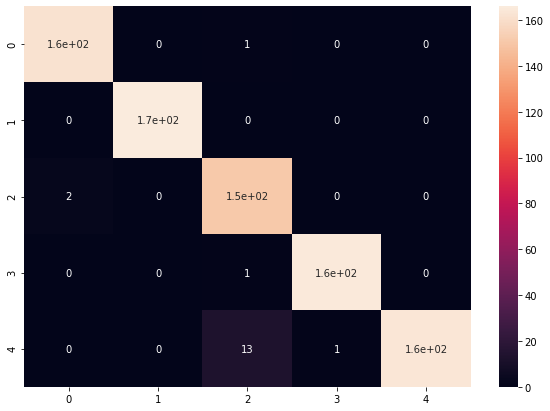

In [24]:
print(nombres_fruta_test)
f, ax = plt.subplots(figsize=(10, 7))

sns.heatmap(df_confusion_5_frutas,annot=True)
